## Splink data linking demo (link only)

In this demo we link two small datasets.  

We assume we have a list of people in one table who we want to find in a larger table.  It is assumed that due to transcription or other errors, there will often not be an exact match.

The larger table contains duplicates, but in this notebook we use the `link_only` setting, so `splink` makes no attempt to deduplicate these records.    Note it is possible to simultaneously link and dedupe using the `link_and_dedupe` setting.

**Important** Where deduplication is not required, `link_only` can provide an important performance boost by dramatically reducing the number of records which need to be compared.

For example, if you wanted to link 10 records to 1,000, then the maximum number of comparisons that need to be made (i.e. with no blocking rules) is 10,000.  If you need to dedupe as well, that number would be n(n-1)/2 = 509,545.

I print the output at each stage using `spark_dataframe.show()`.  This is for instructional purposes only - it degrades performance and shouldn't be used in a production setting.

## Step 1:  Imports and setup

The following is just boilerplate code that sets up the Spark session and sets some other non-essential configuration options

In [1]:
import pandas as pd 
pd.options.display.max_columns = 500

In [2]:
import logging 
logging.basicConfig()  # Means logs will print in Jupyter Lab

# Set to DEBUG if you want splink to log the SQL statements it's executing under the hood
logging.getLogger("splink").setLevel(logging.INFO)

In [3]:
from utility_functions.demo_utils import get_spark
spark = get_spark()

## Step 2: Read in the data

The `l` and `r` stand for 'left' and 'right.  It doesn't matter which of the two datasets you choose as the left, performance and results will be the same.

⚠️ Note that `splink` makes the following assumptions about your data:

-  There is a field containing a unique record identifier in each dataset
-  The two datasets being linked have common column names - e.g. date of birth is represented in both datasets in a field of the same name.   In many cases, this means that the user needs to rename columns prior to using `splink`


In [4]:
df_l = spark.read.parquet("data/fake_df_l.parquet")
df_r = spark.read.parquet("data/fake_df_r.parquet")
df_l.show(5)
df_r.show(5)

+---------+----------+-------+----------+------------+--------------------+-----+
|unique_id|first_name|surname|       dob|        city|               email|group|
+---------+----------+-------+----------+------------+--------------------+-----+
|        0|    Julia |   null|2015-10-29|      London| hannah88@powers.com|    0|
|        4|      oNah| Watson|2008-03-23|      Bolton|matthew78@ballard...|    1|
|       13|    Molly |   Bell|2002-01-05|Peterborough|                null|    2|
|       15| Alexander|Amelia |1983-05-19|     Glasgow|ic-mpbell@alleale...|    3|
|       20|    Ol vri|ynnollC|1972-03-08|    Plymouth|derekwilliams@nor...|    4|
+---------+----------+-------+----------+------------+--------------------+-----+
only showing top 5 rows

+---------+----------+-------+----------+------+--------------------+-----+
|unique_id|first_name|surname|       dob|  city|               email|group|
+---------+----------+-------+----------+------+--------------------+-----+
|        

## Step 3:  Configure splink using the `settings` object

Most of `splink` configuration options are stored in a settings dictionary.  This dictionary allows significant customisation, and can therefore get quite complex.  

💥 We provide an tool for helping to author valid settings dictionaries, which includes tooltips and autocomplete, which you can find [here](http://robinlinacre.com/splink_settings_editor/).

Customisation overrides default values built into splink.  For the purposes of this demo, we will specify a simple settings dictionary, which means we will be relying on these sensible defaults.

To help with authoring and validation of the settings dictionary, we have written a [json schema](https://json-schema.org/), which can be found [here](https://github.com/moj-analytical-services/splink/blob/master/splink/files/settings_jsonschema.json).  




In [5]:
settings = {
    "link_type": "link_only", 
    "max_iterations": 5,
    "blocking_rules": [
        'l.first_name = r.first_name',
        'l.surname = r.surname',
        'l.dob = r.dob'
    ],
    "comparison_columns": [
       {
        "custom_name": "name_inversion",
        "custom_columns_used": ["first_name", "surname", "dob"],
        "case_expression": "CASE WHEN first_name_l = first_name_r AND surname_l = surname_r THEN 2 WHEN first_name_l = surname_r AND surname_l = first_name_r THEN 1 ELSE 0 END",
        "num_levels": 3
        },
        {
            "col_name": "dob"
        },
        {
            "col_name": "city"
        },
        {
            "col_name": "email"
        }
    ],
    "additional_columns_to_retain": ["group"]
    
}

In words, this setting dictionary says:

- We are performing a data linking task (the other options are `dedupe_only`, or `link_and_dedupe`)
- Rather than generate all possible comparisons (the cartesian product of the input datasets), we are going restrict record comparisons to those generated by at least one of the rules in the specified array
- When comparing records, we will use information from the `first_name`, `surname`, `dob`, `city` and `email` columns to compute a match score.
- For `first_name` and `surname`, string comparisons will have three levels:
    - Level 2: Strings are (almost) exactly the same
    - Level 1: Strings are similar 
    - Level 0: No match
- We will make adjustments for term frequencies on the `first_name` and `surname` columns
- We will retain the `group` column in the results even though this is not used as part of comparisons.  This is a labelled dataset and `group` contains the true match - i.e. where group matches, the records pertain to the same person

## Step 4:  Estimate match scores using the Expectation Maximisation algorithm

In [6]:
from splink import Splink

linker = Splink(settings, spark, df_l=df_l, df_r=df_r)
df_e = linker.get_scored_comparisons()

# Later, we will make term frequency adjustments.  
# Persist caches these results in memory, preventing them having to be recomputed when we make these adjustments.
df_e.persist()  


INFO:splink.iterate:Iteration 0 complete
INFO:splink.params:The maximum change in parameters was 0.4944548845291138 for key π_gamma_name_inversion_prob_dist_match_level_0_probability
INFO:splink.iterate:Iteration 1 complete
INFO:splink.params:The maximum change in parameters was 0.054529160261154175 for key π_gamma_city_prob_dist_match_level_0_probability
INFO:splink.iterate:Iteration 2 complete
INFO:splink.params:The maximum change in parameters was 0.026873305439949036 for key π_gamma_city_prob_dist_match_level_0_probability
INFO:splink.iterate:Iteration 3 complete
INFO:splink.params:The maximum change in parameters was 0.016269318759441376 for key π_gamma_email_prob_dist_match_level_0_probability
INFO:splink.iterate:Iteration 4 complete
INFO:splink.params:The maximum change in parameters was 0.013959884643554688 for key π_gamma_email_prob_dist_match_level_1_probability


DataFrame[match_probability: double, unique_id_l: bigint, unique_id_r: bigint, first_name_l: string, first_name_r: string, surname_l: string, surname_r: string, dob_l: string, dob_r: string, gamma_name_inversion: int, prob_gamma_name_inversion_non_match: double, prob_gamma_name_inversion_match: double, gamma_dob: int, prob_gamma_dob_non_match: double, prob_gamma_dob_match: double, city_l: string, city_r: string, gamma_city: int, prob_gamma_city_non_match: double, prob_gamma_city_match: double, email_l: string, email_r: string, gamma_email: int, prob_gamma_email_non_match: double, prob_gamma_email_match: double, group_l: bigint, group_r: bigint]

## Step 5: Inspect results 



In [7]:
# Inspect main dataframe that contains the match scores
df_e.toPandas().sample(5)

,match_probability,unique_id_l,unique_id_r,first_name_l,first_name_r,surname_l,surname_r,dob_l,dob_r,gamma_name_inversion,prob_gamma_name_inversion_non_match,prob_gamma_name_inversion_match,gamma_dob,prob_gamma_dob_non_match,prob_gamma_dob_match,city_l,city_r,gamma_city,prob_gamma_city_non_match,prob_gamma_city_match,email_l,email_r,gamma_email,prob_gamma_email_non_match,prob_gamma_email_match,group_l,group_r
1184,0.008382,89,746,Chirla,None,Taylor,Taylor,2006-06-28,1993-06-23,0,0.992115,0.655863,0,0.951687,0.143546,London,None,-1,1.000000,1.000000,mbrooks@booker.com,rhondawilliams@gonzalez-scott.com,0,0.985161,0.133354,18,129
1295,0.008382,220,870,Amber,Arabella,Smith,Smith,2003-05-12,2004-10-25,0,0.992115,0.655863,0,0.951687,0.143546,None,Leeds,-1,1.000000,1.000000,barrerakevin@sherman.org,kathryn20@goodman.com,0,0.985161,0.133354,39,152
744,0.002238,79,159,Carr,Brown,Ethan,Ethan,2013-01-21,2010-12-22,0,0.992115,0.655863,0,0.951687,0.143546,London,Manchester,0,0.821861,0.218104,stacyball@medina.biz,petersbrandon@cox.com,0,0.985161,0.133354,16,28
868,0.002238,721,364,Sienna,Nancy,Taylor,Taylor,2005-06-04,1989-07-25,0,0.992115,0.655863,0,0.951687,0.143546,Liverpool,London,0,0.821861,0.218104,javierfrederick@kelly.org,wagnershane@landry.com,0,0.985161,0.133354,124,62
1141,0.002238,682,672,None,Ivy,Taylor,Taylor,2014-03-20,1980-01-13,0,0.992115,0.655863,0,0.951687,0.143546,London,noLdo,0,0.821861,0.218104,eaul44@bpntly.com,jonesjennifer@pitts.com,0,0.985161,0.133354,115,113


The `params` property of the `linker` is an object that contains a lot of diagnostic information about how the match probability was computed.  The following cells demonstrate some of its functionality

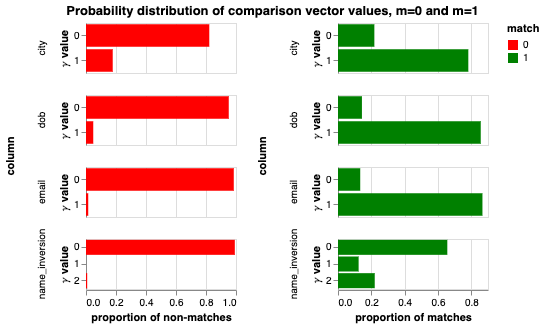

In [13]:
params = linker.params
params.probability_distribution_chart()

An alternative representation of the parameters displays them in terms of the effect different values in the comparison vectors have on the match probability:

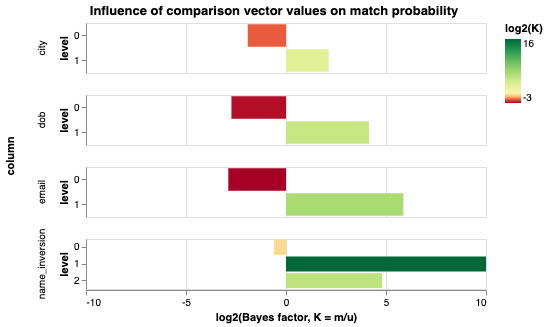

In [14]:
params.bayes_factor_chart()

In [15]:
# If charts aren't displaying correctly in your notebook, you can write them to a file (by default splink_charts.html)
params.all_charts_write_html_file("splink_charts.html", overwrite=True)

You can also generate a report which explains how the match probability was computed for an individual comparison row.  

Note that you need to convert the row to a dictionary for this to work

In [16]:
from splink.intuition import intuition_report
row_dict = df_e.toPandas().sample(1).to_dict(orient="records")[0]
print(intuition_report(row_dict, params))


Initial probability of match (prior) = λ = 0.3851017951965332

Comparison of name_inversion.  Values are:
name_inversion_l: Adam , Berry, 1986-02-08
name_inversion_r: Adam , Berry, 1986-04-25
Comparison has 3 levels
𝛾 for this comparison = gamma_name_inversion = 2
Amongst matches, m = P(𝛾|match) = 0.22041095793247223
Amongst non matches, u = P(𝛾|non-match) = 0.007882719859480858
Bayes factor = m/u = 27.9612826361418
New probability of match (updated belief): 0.9459802391792113

Comparison of dob.  Values are:
dob_l: 1986-02-08
dob_r: 1986-04-25
Comparison has 2 levels
𝛾 for this comparison = gamma_dob = 0
Amongst matches, m = P(𝛾|match) = 0.14354592561721802
Amongst non matches, u = P(𝛾|non-match) = 0.9516867995262146
Bayes factor = m/u = 0.15083315822882126
New probability of match (updated belief): 0.7253767056066094

Comparison of city.  Values are:
city_l: London
city_r: Londn
Comparison has 2 levels
𝛾 for this comparison = gamma_city = 1
Amongst matches, m = P(𝛾|match) = 0.781896